# Znakowanie i identyfikacja kodu wygenerowanego przez AI

Temat automatycznej generacji kodu źródłowego przez Sztuczną Inteliencję (AI) jest obszerny i obejmuje różne techniki, modele oraz zastosowania. Przedmiotem naszego zainteresowania na kursie jest natomiast znalezienie sposobu na zrozumienie czy popularne generatory kodu (i ogólnego użycia) tworzą go w specyficzny dla siebie sposób, i jak tak to jaki. Chcemy odpowiedzieć na pytanie czy w dostarczonym kodzie można odnaleźć pewne statystyczne wzorce - czyli, czy AI posiada swój styl mogący go później zidentyfikować jako autora - podobnie do programistów.

---

Naszą pierwszą czynnością było wygenerowanie kilku prostych matematycznych funkcji i algorytmów w języku Python przy użyciu ChatGPT. Już na pierwszy rzut okna dało się zauważyć pewne elementy, które mogłyby odbiegać od *normy*:
- kod nie korzysta możliwości Pythona co do pisania zwięzłych i bardziej złożonych struktur syntaktycznych
- przy każdej operacji pojawia się komentarz zaczynający się od wielkiej litery, a zmienne wykorzystywane mają dokładnie taką nazwę jak w komentarzu

Celem jest znalezienie **statystycznego** potwierdzenia naszej intuicji, oraz znalezienie **ukrytych artefaktów** o ile istnieją - za pomocą różnych metod i narzędzie programistycznych.

Zadanie detekcji, czy dany fragement kodu został napisany przez AI okazał się niezbyt dobrze opisanym w literaturze tematem, a przynajmniej takie odnieślismy wrażenie. Większość artykułów dotyczyło danych w postaci **tekstowej**. Kod oczywiście również jest zapisany w postaci tekstowej, jednak języki programowania ze względu na swoje przeznaczenie różnią się w aspektach gramatycznych i składniowych, które potrafiły być czynnikiem decydującym o decyzji czy badany tekst jest dziełem człowieka czy AI.
Wyżej wymienione przypuszczenia przykuły też uwagę innych badaczy [1](https://arxiv.org/abs/2405.16133), którzy również zwrócili uwagę na dysproporcję w dokumentacji wykrywania wygenerowanych przez AI fragmentów kodu a tekstu i niedostępności datasetów - co było trochę oczekiwane, ponieważ dopiero od w miare niedługiego okresu, rozwiązania AI stały się użytecznym narzędziem a zarazem problemem.

W swoim artykule zaprezentowali metodę wykrywania polegającą na porównaniu przepisywania przez AI kodu przygotowanego przez 1. człowieka i 2. ai. 

![llm rewriting](./assets/llmrewriting.png)

Dzięki tej obserwacji przygotowali dataset z sztucznie wygenerowanymi funkcjami, z którego możemy skorzystać. Jednak zdecydowali się nauczyć model, a my chcemy **deterministycznie** znaleźć te różnice.

W innym znalezionym badaniu [2](https://ieeexplore.ieee.org/document/9674263/), badacze zdecydowali się stworzyć algorytm heurystyczny, który uwzględniał analizę programów z repozytoriów.

![heurystyka](./assets/heurystyka.png)

Na jego podobieństwo zbudowaliśmy własny algorytm heurystyczny, który mimo swojej prostoty i małej próbki danych potrafił wskazać na pochodzenie syntetyczne lub nie:

In [2]:
import os
import ast
import re
from collections import defaultdict


def analyze_code_heuristic(code, filename):
    results = {"Filename": filename}

    # Keyword Distribution
    keywords = ['if', 'else', 'for', 'while', 'def', 'class', 'try', 'except']
    keyword_distribution = {kw: len(re.findall(r'\b' + kw + r'\b', code)) for kw in keywords}
    results["Keyword Distribution"] = keyword_distribution

    # Naming Conventions
    pascal_case = len(re.findall(r'\b[A-Z][a-z]*[A-Z][a-z]*\b', code))
    snake_case = len(re.findall(r'\b[a-z]+(_[a-z]+)+\b', code))
    results["Naming Conventions"] = {"PascalCase": pascal_case, "snake_case": snake_case}
 
    # Comment Analysis
    comments = re.findall(r'#.*', code)
    average_comment_length = sum(len(comment) for comment in comments) / len(comments) if comments else 0
    overly_detailed_comments = sum(1 for comment in comments if len(comment) > 40)
    results["Comments"] = {
        "Total Comments": len(comments),
        "Average Length": average_comment_length,
        "Overly Detailed Comments": overly_detailed_comments
    }

    # Cyclomatic Complexity
    tree = ast.parse(code)
    complexity = 1
    for node in ast.walk(tree):
        if isinstance(node, (ast.If, ast.For, ast.While, ast.Try, ast.FunctionDef)):
            complexity += 1
    results["Cyclomatic Complexity"] = complexity

    # Code Duplication Detection
    def find_duplicate_functions(tree):
        function_names = defaultdict(list)
        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                function_names[node.name].append(ast.get_source_segment(code, node))

        duplicates = {name: func_code for name, func_code in function_names.items() if len(func_code) > 1}
        return duplicates

    duplicates = find_duplicate_functions(tree)
    results["Duplicate Functions"] = {name: len(funcs) for name, funcs in duplicates.items()}

    # Repetitive Patterns Check
    repetitive_patterns = re.findall(r'\b\w+\b', code)
    repetitive_count = len([word for word in repetitive_patterns if repetitive_patterns.count(word) > 3])
    results["Repetitive Patterns"] = repetitive_count

    # Variable & Function Naming Analysis
    overly_descriptive_names = sum(
        1 for name in re.findall(r'\b[a-zA-Z_]{10,}\b', code) if '_' in name
    )
    results["Overly Descriptive Names"] = overly_descriptive_names

    # Simple Logic and Default Values
    default_values = len(re.findall(r'\b=\s*[\'\"\d\[\]\{\}\(\)]', code))
    results["Default Values"] = default_values

    # Exception Handling
    exception_handlers = len(re.findall(r'\btry\b.*?\bexcept\b', code, re.DOTALL))
    results["Exception Handling"] = exception_handlers

    # AI Generated Probability
    ai_score = 0
    total_weight = 9

    ai_score += (complexity < 10) * (1 / total_weight)
    ai_score += (average_comment_length > 15) * (2 / total_weight)
    ai_score += (pascal_case == 0) * (1 / total_weight)
    ai_score += (snake_case > 0) * (1 / total_weight)
    ai_score += (len(duplicates) > 0) * (0.5 / total_weight)
    ai_score += (repetitive_count > 5) * (1 / total_weight)
    ai_score += (overly_descriptive_names > 2) * (1 / total_weight)
    ai_score += (default_values > 2) * (0.5 / total_weight)
    ai_score += (exception_handlers <= 2) * (1 / total_weight)

    ai_probability = ai_score * 100
    results["AI Generated Probability (%)"] = round(ai_probability, 2)

    return results


def analyze_directory(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".py"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                code = file.read()
                results = analyze_code_heuristic(code, filename)

                print(f"=== Analysis for {directory}/{filename} ===")
                # for key, value in results.items():
                #     print(f"{key}: {value}")
                print(f"'AI Generated Probability (%): {results['AI Generated Probability (%)']}")
                print("\n")


analyze_directory('code_samples/ai')
print("========================\n")
analyze_directory('code_samples/human')

=== Analysis for code_samples/ai/binary_search.py ===
'AI Generated Probability (%): 77.78


=== Analysis for code_samples/ai/bubble_sort.py ===
'AI Generated Probability (%): 77.78


=== Analysis for code_samples/ai/factorial.py ===
'AI Generated Probability (%): 77.78


=== Analysis for code_samples/ai/fib.py ===
'AI Generated Probability (%): 88.89


=== Analysis for code_samples/ai/is_prime.py ===
'AI Generated Probability (%): 77.78


=== Analysis for code_samples/ai/palindrome.py ===
'AI Generated Probability (%): 77.78



=== Analysis for code_samples/human/binary_search.py ===
'AI Generated Probability (%): 66.67


=== Analysis for code_samples/human/bubble_sort.py ===
'AI Generated Probability (%): 44.44


=== Analysis for code_samples/human/factorial.py ===
'AI Generated Probability (%): 33.33


=== Analysis for code_samples/human/fib.py ===
'AI Generated Probability (%): 44.44


=== Analysis for code_samples/human/is_prime.py ===
'AI Generated Probability (%): 44.44


=== An

Dla przygotowanych - małolicznych próbek, obliczone prawdopodobieństwa przyjmują zauważalnie wyższe wartości dla syntetycznych kodów
___

## Znakowanie kodu

W trakcie zajęć lekko zmodyfikowano temat projektu, mianowicie odeszliśmy od zagadnienia wygenerowanych kodów, na rzecz znakowania **naszego** kodu. Celem jest teraz poszukiwanie i implementacja znanych metod do watermarkingu, by można było przekazać kod funkcji markującej a następnie dało się potwierdzić istnienie nałożonych przez nas wzorów.

---

### Niewidzialne znaki końca linii SPACE 0, TAB 1

Kolejnym etapem jest skupienie się na sposobie zakodowania kodu - spróbowaliśmy zawrzeć wzorzec do kodu. Mianowicie, dla wybranego tekstu kodu, w co drugiej linijce dodajemy spację lub tabulator do końca linii. Te znaki będą nam mówić o wartości bitu. 
- spacja = 0
- tab = 1

Znaki są ustawiane w taki sposób, aby odczytując kod z góry do dołu tworzyły nam się bloki bajtowe, które są kodem litery naszego hasła.
Limitacją na razie jest długość kodu i długość hasła, ale to będzie ulepszane. 

In [45]:
def add_watermark_space_tab(code, watermark="LABORATORIA"):
    
    watermark_space_tab_list = ['\t' if bit == '1' else ' ' for bit in ''.join(format(ord(c), '08b') for c in watermark)]
    watermark_binary = 'x'.join([ format(ord(c), '08b') for c in watermark])
    watermark_list = list(watermark)
    
    print("Watermark", watermark_list)
    print("Watermark binary:", watermark_binary)
    #print("Watermark char list:", watermark_space_tab_list)
    print('Dlugosc watermarku: ' + str(len(watermark)))
    print('Dlugosc binarna watermarku: ' + str(len(watermark_space_tab_list)))
    print()
    
    lines = code.splitlines()
    
    
    # -------------------
    # code length aware
    
    # every 2 lines, so scope is n*len(watermark_space_tab_list)
    n = 2
    
    if len(lines) > n * len(watermark_space_tab_list):
        
        needed_bites = len(lines) // n
        current_bites = len(watermark_space_tab_list)
        
        bites_to_add = needed_bites - current_bites
        
        # ile liter potrzebnych
        m = bites_to_add // 8
        # litery + 1 by nie bawić się w części
        m = m + 1
        
        # ile tych liter do czesc watermarka
        k = m // len(watermark_list)
        r = m % len(watermark_list)
        
        watermark_list += k * watermark_list
        watermark_list += watermark_list[:r]
        
        watermark_space_tab_list = ['\t' if bit == '1' else ' ' for bit in ''.join(format(ord(c), '08b') for c in watermark_list)]
        
            
    # -------------------
    
    for i in range(1, len(lines), n):
        lines[i] += watermark_space_tab_list[i // n]
            
    
    return '\n'.join(lines)


def extract_watermark_space_tab(code):
    lines = code.splitlines()

    binary_pattern = []
    for i in range(1, len(lines), 2):
        if lines[i].endswith(" ") or lines[i].endswith("\t"):
            last_char = lines[i][-1]
            binary_pattern.append('1' if last_char == '\t' else '0')

    print("BINARY PATTERN", binary_pattern)
    watermark_text = ''
    for i in range(0, len(binary_pattern), 8):
        byte = ''.join(binary_pattern[i:(i + 8)])
        if len(byte) == 8:
            watermark_text += chr(int(byte, 2))

    return watermark_text if watermark_text else "Brak znaku wodnego"


with open("init-code/init_long.py", "r") as f:
    code_example = f.read()


# -------------------------------------------------------------

watermarked_code = add_watermark_space_tab(code_example)
#print("Zwatermarkowany kod:\n" + watermarked_code)

detected_watermark = extract_watermark_space_tab(watermarked_code)
print("Znaleziony kod:", detected_watermark)


Watermark ['L', 'A', 'B', 'O', 'R', 'A', 'T', 'O', 'R', 'I', 'A']
Watermark binary: 01001100x01000001x01000010x01001111x01010010x01000001x01010100x01001111x01010010x01001001x01000001
Dlugosc watermarku: 11
Dlugosc binarna watermarku: 88

BINARY PATTERN ['0', '1', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1']
Znaleziony kod: LABORATORIALAB


---

### Sortowanie importów

Poniższy kod realizuje dodanie watermarka do sekcji importow w taki sposob ze sortuje je wedlug hash'a `sha256`. \
Widoczna jest również metoda która sprawdza czy zmieniony kod zawiera w sobie watermarka.

Obserwujemy również wyniki:

Czy kod zawiera watermark?
True

Czy oryginalny kod zawiera watermark?
False

In [44]:
import hashlib

def add_watermark_in_imports(code, watermark):
    lines = code.splitlines()
    
    imports = [line for line in lines if line.startswith("import") or line.startswith("from")]
    other_lines = [line for line in lines if not (line.startswith("import") or line.startswith("from"))]
    
    # hash
    watermark_hash = hashlib.sha256(watermark.encode()).hexdigest()
    # sort
    sorted_imports = sorted(imports, key=lambda x: hashlib.sha256((x + watermark_hash).encode()).hexdigest())
    return '\n'.join(sorted_imports + other_lines)

def is_watermarked_imports(code, watermark):
    lines = code.splitlines()
    
    imports = [line for line in lines if line.startswith("import") or line.startswith("from")]
    
    watermark_hash = hashlib.sha256(watermark.encode()).hexdigest()
    sorted_imports = sorted(imports, key=lambda x: hashlib.sha256((x + watermark_hash).encode()).hexdigest())
    
    return imports == sorted_imports


example_code = """

import os
from math import sqrt
import sys
from collections import defaultdict
from itertools import permutations

def example_function():
    print("Hello, World!")
    return 42

def calculate_square_root(x):
    return sqrt(x)

def list_permutations(iterable):
    return list(permutations(iterable))
    
"""

watermarked_code = add_watermark_in_imports(example_code, "UniqueWatermark2024")
print("Kod po dodaniu watermarku:\n")
print(watermarked_code)

print("\nCzy kod zawiera watermark?")
is_watermarked = is_watermarked_imports(watermarked_code, "UniqueWatermark2024")
print(is_watermarked)

print("\nCzy oryginalny kod zawiera watermark?")
not_watermarked = is_watermarked_imports(example_code, "UniqueWatermark2024")
print(not_watermarked)


Kod po dodaniu watermarku:

from math import sqrt
import os
from itertools import permutations
import sys
from collections import defaultdict



def example_function():
    print("Hello, World!")
    return 42

def calculate_square_root(x):
    return sqrt(x)

def list_permutations(iterable):
    return list(permutations(iterable))
    

Czy kod zawiera watermark?
True

Czy oryginalny kod zawiera watermark?
False


---

### Dodawanie *stylu*

Poniższy kod realizuje zamiane znaków w ich podobne odpowiedniki np. `l -> 1` \
Kod pomija wbudowane nazwy oraz pomija pierwsze znaki po to, żeby możliwa była kompilacja zwatermarkowanego kodu. \
Przykładowa zmiana nazwy zmiennej `total -> tota1`. \
Dodatkowo dodana została funkcja sprawdzająca watermark.

Przykładowy wynik:
Czy kod zawiera watermark w zmiennych i parametrach?
True

Czy oryginalny kod zawiera watermark w zmiennych i parametrach?
False

Problemem może być brak estetyczności kodu, i wyraźną chęć przepisania bądź zmiany nazw zmiennych

In [20]:
import hashlib
import re
import keyword

SIMILAR_CHARS = {
    'a': '@',
    'e': '3',
    'i': '1',
    'o': '0',
    'l': '1',
    's': '5',
    't': '7'
}

BUILTINS = dir(__builtins__)

def add_watermark_in_variables_similar_chars(code, watermark):

    # wsm to ten hash nie jest wykorzystywany skoro i jak dajemy len(watermark_hash) ()= 4) jako warunek sprawdzający można by dodać jakoś zmienić na idk // 1000 
    watermark_hash = hashlib.sha256(watermark.encode()).hexdigest()[:4]
    #print("W HASH:", watermark_hash, type(watermark_hash))
    #hash_n = int(watermark_hash[0])
    hash_n = int(re.sub(r'\D', '1', watermark_hash)[0])
    
    def modify_variable(name):
        if name in keyword.kwlist or name in BUILTINS:
            return name
        
        modified_name = name[0]
        for i, char in enumerate(name[1:], 1):
            if char.lower() in SIMILAR_CHARS and i % hash_n == 0:
                modified_name += SIMILAR_CHARS[char.lower()]
            else:
                modified_name += char
        return modified_name

    variable_pattern = re.compile(r'\b([a-zA-Z_][a-zA-Z0-9_]*)\b')
    lines = code.splitlines()
    updated_lines = []
    
    for line in lines:
        updated_line = variable_pattern.sub(
            lambda match: modify_variable(match.group(1)), line)
        
        updated_lines.append(updated_line)
    
    return '\n'.join(updated_lines)

def is_watermarked_variables_similar_chars(code, watermark):

    watermark_hash = hashlib.sha256(watermark.encode()).hexdigest()[:4]
    #hash_n = int(watermark_hash[0])
    hash_n = int(re.sub(r'\D', '1', watermark_hash)[0])
    
    def check_variable(name):

        original_name = name[0]
        for i, char in enumerate(name[1:], 1):
            if char in SIMILAR_CHARS.values() and i % hash_n == 0:
                original_char = next((k for k, v in SIMILAR_CHARS.items() if v == char), None)
                if original_char:
                    original_name += original_char
                else:
                    return False
            else:
                original_name += char
        
        return original_name != name

    variable_pattern = re.compile(r'\b([a-zA-Z_][a-zA-Z0-9_]*)\b')
    for match in variable_pattern.findall(code):
        if check_variable(match):
            return True
    
    return False


example_code = """

def calculate_area(length, width):
    result = length * width
    return result

def greet_user(name):
    greeting = f"Hello, {name}!"
    print(greeting)

def compute_sum(numbers):
    total = 0
    print("--")
    for num in numbers:
        total += num
    print(total)
    return total
    
"""

watermark_vars = "ImprovedWatermark2024x"

watermarked_code = add_watermark_in_variables_similar_chars(example_code, watermark_vars)
print("Kod po dodaniu watermarku z podobnymi znakami:\n")
print(watermarked_code)

print("\nCzy kod zawiera watermark w zmiennych i parametrach?")
is_watermarked = is_watermarked_variables_similar_chars(watermarked_code, watermark_vars)
print(is_watermarked)

print("\nCzy oryginalny kod zawiera watermark w zmiennych i parametrach?")
not_watermarked = is_watermarked_variables_similar_chars(example_code, watermark_vars)
print(not_watermarked)


Kod po dodaniu watermarku z podobnymi znakami:



def calcul@te_ar3a(length, width):
    result = length * width
    return result

def greet_user(name):
    greeting = f"Hello, {name}!"
    print(greeting)

def comput3_sum(number5):
    total = 0
    print("--")
    for num in number5:
        total += num
    print(total)
    return total
    

Czy kod zawiera watermark w zmiennych i parametrach?
True

Czy oryginalny kod zawiera watermark w zmiennych i parametrach?
False


---

### Inne niewidzialne znaki

Następnymi krokami, które chcieliśmy przetestować to:

- dodawanie znaku NULL (char - 0) lub Zero-Width Space (utf-8 200B), do każdego stringu obecnego w kodzie. 
    

- dodawanie zmiennej liczby znaków wybranych znaków do każdej linii, tak aby nawet po usunięciu kilku linijek, po odczytaniu liczby tych znaków można by spróbować statystycznie zweryfikować czy te dane pochodzą z wybranego przez nas rozkładu. Zapewne musiałby byc to rozkład normalny, ale z niezbyt dużą wartością średnią, żeby edytor kodu nie był w stanie wykryć *slidera*. Ale może gdyby dodawać znaku null to można by je dodawać z innego rozkładu - i to w kontekście każdej napotkanej funkcji, głównie wokół których zorganizowany jest kod. Takie sprawdzenie moglibyśmy zweryfikować m.in. szukając nadjdłuższego wspoólnego podciągu LCS...

**JEDNAK EKSPERYMENTY Z INNYMI ZNAKAMI TEKSTU** nie działają jak zakładaliśmy, Python ma w tym elemencie surową politykę i dodane znaki na końcu linii powodują widoczne w popularnych ide zmiany, które dodatkowo  uniemożliwiają działanie kodu, więc zostają **PORZUCONE** na ten moment i zostajemy przy neutralnych `" "` i `"\t"`. 



In [ ]:
import numpy as np
import random
import hashlib
import re
    

def add_multiple_inv_sign_watermark(code, watermark):

    watermark_hash = hashlib.sha256(watermark.encode()).hexdigest()[:4]
      
    hash_n = int(re.sub(r'\D', '1', watermark_hash))
    random.seed(hash_n)
    
    pattern = []
    lines = code.splitlines()
    for i in range(len(lines)):
        n = random.choice(range(4))
        lines[i] += n * " "     
        pattern.append(n)       

    return '\n'.join(lines), pattern


'''
def add_null_watermark(code):

    lines = code.splitlines()
    for i in range(len(lines)):
        print("LEN LINE BEFORE:", len(lines[i]))
        lines[i] += random.choice(range(1,4))*chr(0)
            
        print("LEN LINES AFTER:", len(lines[i]))
        print("-")

    return ''.join(lines)

def add_zws_watermark(code):

    lines = code.splitlines()
    for i in range(len(lines)):
        print("LEN LINE BEFORE:", len(lines[i]))
        lines[i] += random.choice(range(1,4))*"\u200B"
            
        print("LEN LINES AFTER:", len(lines[i]))
        print("-")

    return ''.join(lines)
'''

def extract_multiple_inv_signs_watermark(code):
    
    pattern = []
    lines = code.splitlines()
    
    for line in lines:
        x = re.findall(r" *$", line)
        pattern.append(len(x[0]))   
         
    return pattern

    
def get_func(filepath):
    with open(filepath, "r") as f:
        code_example = f.read()

    return code_example

def save_func(filepath, code):
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(code)
        
    
watermark_dist = "ImprovedWatermark2024x"
   
filename1 = "./code_samples/human/is_prime.py"
filename2 = "./watermarked_code/is_prime_w1.py"

code_watermarked = get_func(filename1)
watermarked_code, original_pattern = add_multiple_inv_sign_watermark(code_watermarked, watermark_dist)
    
save_func(filename2, watermarked_code)

print("P1:", original_pattern)

extracted_pattern = extract_multiple_inv_signs_watermark(watermarked_code)

print("P2:", extracted_pattern)



P1: [0, 3, 1, 3, 3, 1, 2, 3, 0, 1, 2, 2, 0, 3, 3]
P2: [0, 3, 1, 3, 3, 1, 2, 3, 0, 1, 2, 2, 0, 3, 3]


#### Porównanie 2 uzyskanych wzorców:
- użyty do zakodowania różnej informacji o spacjach, np. P1: [0, 3, 1, 3, 3, 1, 2, 3, 0, 1, 2, 2, 0, 3, 3]
- odczytany z kodu, np. P2: [0, 3, 1, 3, 3, 1, 2, 3, 0, 1, 2, 2, 0, 3, 3]

Przy użyciu tradycyjnego algorytmu będziemy chcieli je porównać również dla tekstu nie zmodyfikowanego przez użytkownika, który mógł usunąć pewną linijkę lub usunąc z niektórych spacje, kolejności raczej się nie zmienia.

In [56]:
def LCS(s1, s2, m, n, memo):
 
   # Base Case
    if m == 0 or n == 0:
        return 0

    # Already exists in the memo table
    if memo[m][n] != -1:
        return memo[m][n]

    # Match
    if s1[m - 1] == s2[n - 1]:
        memo[m][n] = 1 + LCS(s1, s2, m - 1, n - 1, memo)
        return memo[m][n]

    # Do not match
    memo[m][n] = max(LCS(s1, s2, m, n - 1, memo),
                     LCS(s1, s2, m - 1, n, memo))
    
    return memo[m][n]

def check_patterns(pattern_list_original, pattern_list_extracted):
    
    original_pattern = list(map(lambda x: str(x), pattern_list_original))
    extracted_pattern = list(map(lambda x: str(x), pattern_list_extracted ))

    p1 = "".join(original_pattern)
    p2 = "".join(extracted_pattern)
    
    m = len(p1)
    n = len(p2)
    memo = [[-1 for _ in range(n + 1)] for _ in range(m + 1)]
    
    p = LCS(p1, p2, m, n, memo)
    
    r =  p / len(original_pattern)
    print("Prawdopodobieństwo ciągów:", r)
    
    return r


filename1 = "./watermarked_code/is_prime_w1.py"
#modified, by removing lines and some spaces
filename2 = "./watermarked_code/is_prime_w2.py" 


watermarked_code_unmodified = get_func(filename1)
watermarked_code_modified = get_func(filename2)

pattern1 = extract_multiple_inv_signs_watermark(watermarked_code_unmodified)
pattern2 = extract_multiple_inv_signs_watermark(watermarked_code_modified)

print("P1:", pattern1)
print("P2:", pattern2)

check_patterns(pattern1, pattern2)



P1: [0, 3, 1, 3, 3, 1, 2, 3, 0, 1, 2, 2, 0, 3, 3]
P2: [0, 0, 0, 3, 1, 2, 3, 0, 2, 2, 0, 1]
Prawdopodobieństwo ciągów: 0.6


0.6

---

### Inna, bardziej zaawansowana metoda steganografii

Tym razem będziemy wzorować się na metodach zaprezentowanych w [3](https://arxiv.org/pdf/1302.2718). Metody, które chcielibyśmy przenieść na warunki programistyczne to:
1. Dodawanie "\_" do nazw zmiennych w odpowiednich miejscach, (zamiast zaproponowanych "?") ich rozmieszczenie w kodzie będzie możliwe do zakodowania pewnych informacji, ale możliwe że będzie wymagało to dodatkowej informacji, aby tak zmodyfikowane zmienne lub nazwy funkcji nie wzbudzały podejrzeń, szczegóły w referowanym pliku - metoda 1: **Missing Letter Puzzle**
2. Nazywanie zmiennych w odpowiedni sposób - metoda 2: **Hiding Data in Wordlist**, tutaj ponownie, prawdopodobne, że wymagałoby to interwencji przez kodującego mając na uwadze pewne ściśle nałożone warunki.


Oczywiście ze względu na strukturę kodu, wprowadzone modyfikacje do nazw musiałyby być uwzględnione globalnie a nie jedynie ad hoc. A raczej napewno wsm, bo będziemy musieli modyfikować długość zmiennej w trakcie algorytmu...

In [ ]:
# ~ Metoda 1: Missing Letter Puzzle: ? -> _, 

def missing_letter_puzzle():
    return

def retrieve_var_names(code):
    var = {
        "name": str,
        "line_of_fist_occurance": int
    }
    vars = set()
    
    lines = code.splitlines()
    for i, line in enumerate(lines):
        a = 2137
        # szukanie wzorców re "|XXX| = YYY", lub "def |ZZZ|"
        
        # jeśli nie był w secie to dodaj 
        
    
    return vars


def hide_mlp():
    return

def seekd_mlp():
    return


In [ ]:
# ~ Metoda 2: Hiding Data in Wordlist

### Testy nieparametryczne, które rozważaliśmy, oraz dlaczego są nieodpowiednie:

---

### 1. **Test Wilcoxona (Wilcoxon Signed-Rank Test)**

- **Opis**: Test Wilcoxona porównuje medianę różnic między dwiema zależnymi próbami. Używa rang różnic, a nie samych różnic, co czyni go odpornym na wpływ ekstremalnych wartości.
  
- **Dlaczego nie pasuje?**  
  W przypadku naszych danych test Wilcoxona działa na rangach różnic, co oznacza, że wielkość procentowych różnic nie wpływa bezpośrednio na wynik. Ponieważ różnice są zawsze spadkowe w naszym przypadku (przed modyfikacją watermark zawsze wynosi 100%), test może nie być wystarczająco wrażliwy na istotne zmiany w wielkości różnic procentowych.

---

### 2. **Test Znaków (Sign Test)**

- **Opis**: Test Znaków analizuje, czy liczba pozytywnych różnic jest istotnie różna od liczby negatywnych różnic. Ignoruje jednak wielkość tych różnic.

- **Dlaczego nie pasuje?**  
  Test Znaków nie uwzględnia wielkości różnic, a jedynie ich kierunek (czy różnica jest dodatnia czy ujemna). W naszym przypadku wszystkie różnice są ujemne, co prowadzi do maksymalnego wyniku testu i braku różnic w p-wartościach, niezależnie od wielkości różnic procentowych.

---

### 3. **Test McNemara**

- **Opis**: Test McNemara jest używany do analizy danych binarnych dla prób zależnych, np. gdy chcemy sprawdzić, czy proporcja sukcesów przed i po interwencji różni się istotnie.

- **Dlaczego nie pasuje?**  
  Nasze dane są procentowe, a nie binarne. Test McNemara wymaga konwersji procentów na dane binarne (np. sukces/porażka przy ustalonej granicy), co prowadzi do utraty informacji o wielkości zmian i zbyt dużego uproszczenia danych.

---

### 4. **Test Manna-Whitneya (Mann-Whitney U Test)**

- **Opis**: Test Manna-Whitneya porównuje mediany dwóch niezależnych grup. Jest to nieparametryczny odpowiednik testu t-Studenta dla prób niezależnych.

- **Dlaczego nie pasuje?**  
  Nasze dane pochodzą z **prób zależnych** (przed i po modyfikacji tego samego kodu), więc test Manna-Whitneya nie jest odpowiedni. Ponadto test ten porównuje mediany dwóch grup, a nie różnice między nimi.

---

### 5. **Test Permutacyjny**

- **Opis**: Test permutacyjny polega na wielokrotnym losowym przekształcaniu danych w celu stworzenia rozkładu statystyki testowej, na podstawie którego można obliczyć p-wartość.

- **Dlaczego nie pasuje?**  
  W naszym przypadku test permutacyjny również może nie być odpowiedni, ponieważ wszystkie różnice są w tym samym kierunku (ujemne). To prowadzi do bardzo małych p-wartości, które są niemal stałe, niezależnie od wielkości zmian procentowych.

---

### 6. **Test Kolmogorowa-Smirnova (K-S Test)**

- **Opis**: Test K-S sprawdza, czy dwa zbiory danych pochodzą z tego samego rozkładu. Może być stosowany do porównywania dwóch rozkładów empirycznych.

- **Dlaczego nie pasuje?**  
  Próbka przed modyfikacją zawsze wynosi 100%, co prowadzi do skrajnie jednostajnego rozkładu. Nie ma sensu porównywać tego z próbką po modyfikacji, ponieważ różnica między rozkładami będzie trywialna i wynika z charakteru danych, a nie z ich statystycznej zmienności.

---

### 7. **Test U (Mann-Whitney U Test dla różnic)**

- **Opis**: Próba wykorzystania testu U do analizy różnic w zależnych próbach poprzez sztuczne rozdzielenie różnic na niezależne grupy.

- **Dlaczego nie pasuje?**  
  Test U wymaga niezależnych grup, a różnice w naszych danych są zależne (pochodzą z tych samych par). Przekształcanie różnic na dwie niezależne grupy jest błędne z punktu widzenia założeń testu.

---

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


C:\Users\makar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\
Python310\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Prawdopodobieństwo, że zmiana mieści się w ROPE (0, 10): 41.34%
Prawdopodobieństwo, że zmiana jest istotna: 58.66%


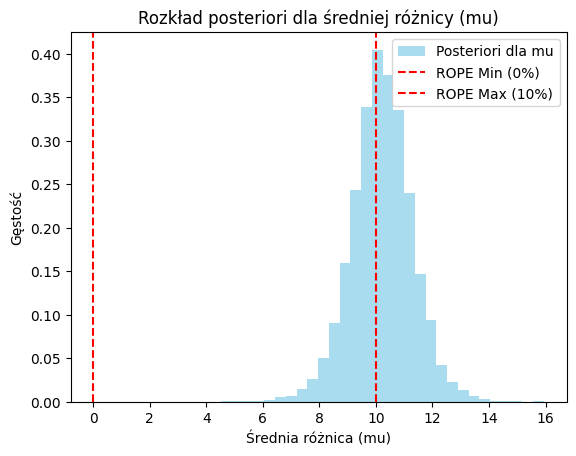

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

before_modification = np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100])
after_modification = np.array([95, 85, 90, 92, 88, 93, 89, 87, 90, 88])

differences = before_modification - after_modification

# Model Bayesowski
with pm.Model() as model:
    # Priorytety
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    # Rozkład różnic
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=differences)
    trace = pm.sample(2000, return_inferencedata=True)

# posteriori
rope_min, rope_max = 0, 10
mu_samples = trace.posterior["mu"].values.flatten()

# ROPE
within_rope = np.mean((mu_samples >= rope_min) & (mu_samples <= rope_max))
outside_rope = 1 - within_rope

print(f"Prawdopodobieństwo, że zmiana mieści się w ROPE (0, 10): {within_rope:.2%}")
print(f"Prawdopodobieństwo, że zmiana jest istotna: {outside_rope:.2%}")

import matplotlib.pyplot as plt
plt.hist(mu_samples, bins=30, density=True, alpha=0.7, color="skyblue", label="Posteriori dla mu")
plt.axvline(rope_min, color="red", linestyle="--", label="ROPE Min (0%)")
plt.axvline(rope_max, color="red", linestyle="--", label="ROPE Max (10%)")
plt.title("Rozkład posteriori dla średniej różnicy (mu)")
plt.xlabel("Średnia różnica (mu)")
plt.ylabel("Gęstość")
plt.legend()
plt.show()


### Zaproponowany test statystyczny

Kod realizuje **podejście Bayesowskie** do analizy różnic procentowych, przy czym wykorzystuje narzędzie ROPE (Region of Practical Equivalence), aby ocenić, czy zmiana różnic (np. w watermarku) jest statystycznie i praktycznie istotna.

#### 1. **Bayesowski test hipotez**:
   - Kod realizuje analizę **Bayesowską**, która różni się od testów klasycznych (np. test t-Studenta, Wilcoxona):
     - **Nie zakłada hipotezy zerowej** (że nie ma efektu) ani alternatywnej.
     - Zamiast tego estymuje rozkład posteriori dla interesujących nas parametrów (\( \mu \), \( \sigma \)).
   - Wynik analizy ROPE:
     - Jeśli większość posteriori mieści się w przedziale ROPE, możemy powiedzieć, że zmiana jest nieistotna **w sensie praktycznym**.
     - Jeśli wartości są poza ROPE, zmiana jest praktycznie istotna.

#### 2. **Nieparametryczne podejście**:
   - Bayesowskie modele pozwalają elastycznie dopasować rozkład posteriori bez założeń o normalności danych (choć w tym przykładzie użyto rozkładu normalnego dla uproszczenia).

#### 3. **Test istotności dla różnic (poprzez ROPE)**:
   - Zamiast sprawdzać tylko, czy różnice są statystycznie istotne (jak w klasycznych testach p-wartości), ten test bada również **praktyczną istotność**.
   - Pozwala to włączyć wiedzę ekspercką (np. \( 10\% \) jako akceptowalny spadek) do procesu decyzyjnego.
